# Imports and Custom Functions

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
#import tensorflow as tf
#tf.enable_v2_behavior()

#import tensorflow_probability as tfp
#tfd = tfp.distributions
#tfb = tfp.bijectors

In [2]:
def closest(lst, K):
    
    number = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    
    if abs(number-K) >= 3:
        print('Not close enough: ', int(abs(number-K)))
    
    # number_index = np.random.choice(get_all_indices(lst,number))
      
    return get_all_indices(lst,number) # number_index

In [3]:
def get_all_indices(mylist,myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

In [4]:
def remove_zeros_distribution(X):

    return [i for i in X if i != 0]

def log_binning_distribution(x_i,B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))

    # b_list.insert(0,b_1)
    # b_list.append(b_Bp1)
    
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

# Analysis of BindingDB Kd

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

There are 70750 drug target pairs.


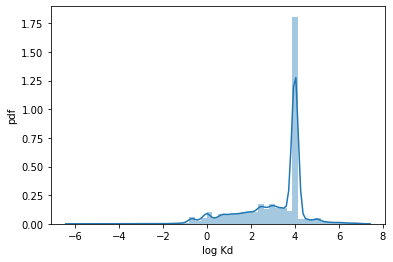

In [5]:
df = pd.read_csv('/home/sars-busters-consolidated/data/BindingDB_All.tsv', sep = '\t', error_bad_lines=False)

df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[df_want.Label <= 10000000.0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')

kd_list = list(df_want.Label.values)

ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')
plt.show()

Text(0, 0.5, 'PDF')

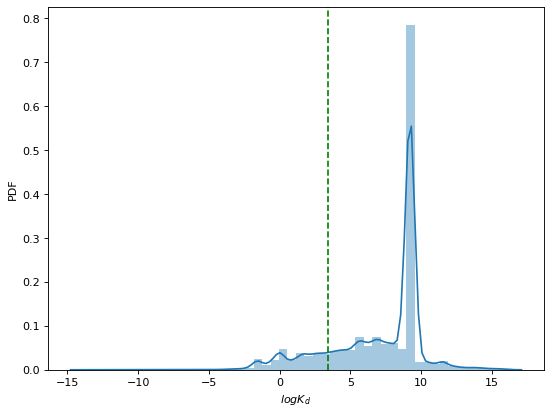

In [72]:
figure(figsize=(8, 6), dpi=80)
sns.distplot(np.log(remove_zeros_distribution(kd_list)), norm_hist=True)
plt.axvline(x=np.log(30),color='green',linestyle='dashed')
plt.xlabel(r'$log K_d$')
plt.ylabel('PDF')

# Randomzing the whole bipartite network

In [6]:
#threshold = 30 # in nM

df_want_Kd = df_want[['SMILES','Target Sequence','Label']]
#df_want_Kd['Kd'] = df_want.Label.values
#df_want_Kd['Label'] = [1 if x<threshold else 0 for x in kd_list]

In [7]:
df_want_Kd

,SMILES,Target Sequence,Label
21470,Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.46
21471,COc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.49
21472,NS(=O)(=O)c1ccc(s1)S(=O)(=O)NCc1cccs1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.83
21473,NS(=O)(=O)c1cc2C(O)CN(Cc3cccs3)S(=O)(=O)c2s1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.20
21474,COc1ccc(cc1)N1CC(O)c2cc(sc2S1(=O)=O)S(N)(=O)=O,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.16
...,...,...,...
2077352,CCCC(=O)c1ccc2Sc3ccccc3N(CCCN3CCN(C)CC3)c2c1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,16600.00
2077353,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc23)CC1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,63100.00
2077354,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)C#N,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,34700.00
2077355,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,38900.00


In [8]:
threshold = 30 

df_want_Kd_binary = pd.DataFrame(df_want_Kd)
df_want_Kd_binary['Label'] = [1 if x < threshold else 0 for x in tqdm(df_want_Kd['Label'].tolist())]

100%|██████████| 70750/70750 [00:00<00:00, 1598826.57it/s]


In [9]:
ligands = list(set(df_want_Kd_binary['SMILES'].tolist()))
targets = list(set(df_want_Kd_binary['Target Sequence'].tolist()))

In [10]:
target_annotations_bindingDB = []
target_pos_degree_bindingDB = []
target_neg_degree_bindingDB = []
target_degree_ratio_bindingDB = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations_bindingDB.append(len(sub_df))
    target_pos_degree_bindingDB.append(sub_df['Label'].tolist().count(1))
    target_neg_degree_bindingDB.append(sub_df['Label'].tolist().count(0))
    target_degree_ratio_bindingDB.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 1507/1507 [00:12<00:00, 119.19it/s]


In [11]:
# p_connection_layer = sum(target_annotations_bindingDB) / (len(targets) * (len(targets)-1))

In [12]:
# randomized_combined_unipartite = nx.fast_gnp_random_graph(len(targets), p_connection_layer)
randomized_combined_unipartite = nx.configuration_model(target_annotations_bindingDB, create_using=nx.Graph())

In [13]:
randomized_combined_unipartite = nx.Graph(randomized_combined_unipartite)

In [14]:
randomized_combined_unipartite.number_of_edges()

28726

# Target Annotaions and Kd

In [15]:
df_want_Kd = df_want[['SMILES','Target Sequence','Label']]

In [16]:
targets = list(set(df_want_Kd['Target Sequence']))
target_annotations = []
target_average_Kd = []

#df_want_Kd = df_want_Kd[df_want_Kd['Label'] != 0]
df_want_Kd['Label'] = list(df_want_Kd['Label'].tolist())

for prot in tqdm(targets):
    sub_df = df_want_Kd[df_want_Kd['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_average_Kd.append(np.mean(sub_df['Label'].tolist()))
    
different_target_annotations = list(set(target_annotations))
unique_Kd_targets = []
unique_Kd_targets_std = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(target_average_Kd[j])
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    unique_Kd_targets_std.append(np.std(all_Kd_list))
    
print('Targets - Between k and <Kd>: ', stats.spearmanr(different_target_annotations,unique_Kd_targets))

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 172/172 [00:00<00:00, 5647.08it/s]

Targets - Between k and <Kd>:  SpearmanrResult(correlation=-0.4673048395959652, pvalue=1.0298775028113185e-10)


Mean and standard deviation of log Kd:  7.104377155054556 3.333661394378017


Text(0, 0.5, 'Average $K_d$')

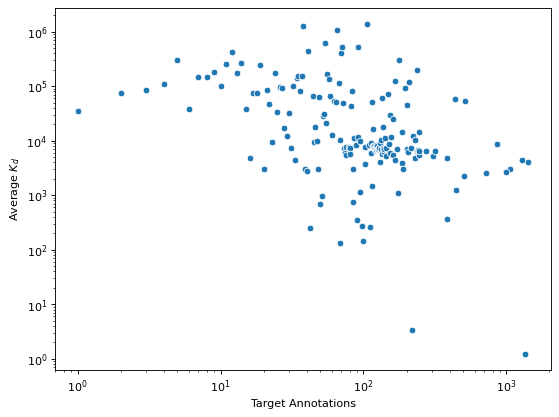

In [17]:
mean_log_Kd = np.mean(np.log(remove_zeros_distribution(kd_list)))
std_log_Kd = np.std(np.log(remove_zeros_distribution(kd_list)))

print('Mean and standard deviation of log Kd: ', mean_log_Kd, std_log_Kd)

figure(figsize=(8, 6), dpi=80)

sns.scatterplot(different_target_annotations,unique_Kd_targets)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Target Annotations')
plt.ylabel(r'Average $K_d$')

In [18]:
targets_degrees_list_plfit = [randomized_combined_unipartite.degree(node) for node in list(randomized_combined_unipartite.nodes())]

print('Average annotations for targets: ', np.mean(targets_degrees_list_plfit))

print('Target degree distribution - Power Law')
print('------------------------------------------------')

results = powerlaw.Fit(targets_degrees_list_plfit)
print(results.power_law.alpha)
print(results.power_law.xmin)

Average annotations for targets:  38.12342402123424
Target degree distribution - Power Law
------------------------------------------------
Calculating best minimal value for power law fit
3.3538720801022723
121.0


In [19]:
mean = [0, 0]
cov = [[1, -0.47], [-0.47, 1]] # Correlation 

In [20]:
x, y = np.random.multivariate_normal(mean, cov, size=100000).T

In [21]:
from scipy.stats import norm  

U1 = norm.cdf(x)
U2 = norm.cdf(y)

In [22]:
Kmin = 1
gamma = results.power_law.alpha

K_copula_list = []
Kd_copula_list = []

for i in tqdm(range(len(U1))):
    K_copula_list.append(int(Kmin * ((1-U1[i]) ** (1/(1-gamma)))))
    Kd_copula_list.append(np.exp(mean_log_Kd + std_log_Kd*norm.ppf(U2[i])))

100%|██████████| 100000/100000 [00:19<00:00, 5054.21it/s]


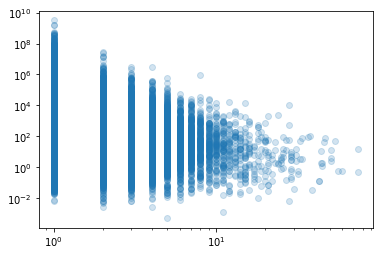

In [23]:
plt.scatter(K_copula_list,Kd_copula_list,alpha=0.2)
plt.xscale('log')
plt.yscale('log')

In [24]:
stats.spearmanr(Kd_copula_list,K_copula_list)

SpearmanrResult(correlation=-0.3250746256030634, pvalue=0.0)

# Adding Randomized Kd Values

In [25]:
target_random_Kd_dict = dict()

for node in tqdm(list(randomized_combined_unipartite.nodes())):
    degree_node = randomized_combined_unipartite.degree(node)
    closest_indices = closest(K_copula_list,degree_node)
    Kd_all_list = []
    for index in closest_indices:
        Kd_all_list.append(Kd_copula_list[index])
    target_random_Kd_dict[node] = Kd_all_list

  1%|          | 12/1507 [00:00<00:42, 35.37it/s]

Not close enough:  31
Not close enough:  7
Not close enough:  3
Not close enough:  4


  1%|▏         | 20/1507 [00:00<00:47, 31.17it/s]

Not close enough:  92


  2%|▏         | 28/1507 [00:00<00:46, 31.55it/s]

Not close enough:  5
Not close enough:  45
Not close enough:  4
Not close enough:  24


  3%|▎         | 40/1507 [00:01<00:45, 32.01it/s]

Not close enough:  23
Not close enough:  33


  3%|▎         | 48/1507 [00:01<00:50, 28.91it/s]

Not close enough:  57


  4%|▎         | 56/1507 [00:01<00:47, 30.30it/s]

Not close enough:  4
Not close enough:  35
Not close enough:  32


  4%|▍         | 63/1507 [00:02<00:49, 29.16it/s]

Not close enough:  4
Not close enough:  90
Not close enough:  176


  5%|▍         | 70/1507 [00:02<00:47, 30.47it/s]

Not close enough:  39
Not close enough:  5
Not close enough:  26
Not close enough:  61


  5%|▌         | 82/1507 [00:02<00:43, 32.56it/s]

Not close enough:  30
Not close enough:  30
Not close enough:  30
Not close enough:  27


  6%|▌         | 90/1507 [00:02<00:47, 29.84it/s]

Not close enough:  110
Not close enough:  23
Not close enough:  20
Not close enough:  35


  7%|▋         | 98/1507 [00:03<00:43, 32.21it/s]

Not close enough:  6
Not close enough:  11


  7%|▋         | 110/1507 [00:03<00:45, 30.90it/s]

Not close enough:  4


  8%|▊         | 122/1507 [00:03<00:45, 30.73it/s]

Not close enough:  28
Not close enough:  13
Not close enough:  23


 10%|▉         | 148/1507 [00:04<00:46, 29.04it/s]

Not close enough:  36
Not close enough:  34


 10%|█         | 156/1507 [00:05<00:43, 30.90it/s]

Not close enough:  30


 11%|█         | 164/1507 [00:05<00:42, 31.38it/s]

Not close enough:  21
Not close enough:  27
Not close enough:  94


 11%|█▏        | 172/1507 [00:05<00:42, 31.48it/s]

Not close enough:  27
Not close enough:  3
Not close enough:  5
Not close enough:  114


 12%|█▏        | 184/1507 [00:05<00:42, 31.43it/s]

Not close enough:  14
Not close enough:  35
Not close enough:  27


 12%|█▏        | 188/1507 [00:06<00:43, 30.57it/s]

Not close enough:  65
Not close enough:  25
Not close enough:  30


 13%|█▎        | 196/1507 [00:06<00:43, 30.48it/s]

Not close enough:  29
Not close enough:  33
Not close enough:  25


 14%|█▍        | 212/1507 [00:06<00:43, 29.80it/s]

Not close enough:  50


 15%|█▍        | 220/1507 [00:07<00:41, 30.85it/s]

Not close enough:  24
Not close enough:  30
Not close enough:  5


 15%|█▌        | 232/1507 [00:07<00:39, 31.98it/s]

Not close enough:  5
Not close enough:  29


 16%|█▌        | 244/1507 [00:07<00:38, 33.09it/s]

Not close enough:  19
Not close enough:  75
Not close enough:  41


 17%|█▋        | 252/1507 [00:08<00:41, 30.24it/s]

Not close enough:  18
Not close enough:  35


 18%|█▊        | 264/1507 [00:08<00:38, 32.47it/s]

Not close enough:  20
Not close enough:  6
Not close enough:  29


 18%|█▊        | 276/1507 [00:08<00:39, 30.87it/s]

Not close enough:  5
Not close enough:  5


 19%|█▉        | 291/1507 [00:09<00:39, 30.98it/s]

Not close enough:  30
Not close enough:  31


 20%|██        | 302/1507 [00:09<00:41, 28.72it/s]

Not close enough:  3
Not close enough:  29


 21%|██        | 309/1507 [00:10<00:39, 30.37it/s]

Not close enough:  42


 21%|██        | 317/1507 [00:10<00:38, 30.69it/s]

Not close enough:  36
Not close enough:  33
Not close enough:  16
Not close enough:  30


 22%|██▏       | 329/1507 [00:10<00:34, 33.85it/s]

Not close enough:  29
Not close enough:  27


 22%|██▏       | 337/1507 [00:10<00:37, 31.60it/s]

Not close enough:  6


 23%|██▎       | 349/1507 [00:11<00:35, 32.58it/s]

Not close enough:  31
Not close enough:  33


 24%|██▎       | 357/1507 [00:11<00:34, 32.89it/s]

Not close enough:  33


 24%|██▍       | 365/1507 [00:11<00:36, 31.48it/s]

Not close enough:  4
Not close enough:  7
Not close enough:  27
Not close enough:  33


 25%|██▍       | 373/1507 [00:12<00:38, 29.49it/s]

Not close enough:  3
Not close enough:  25


 26%|██▌       | 386/1507 [00:12<00:39, 28.70it/s]

Not close enough:  22
Not close enough:  30
Not close enough:  5


 26%|██▋       | 398/1507 [00:12<00:36, 30.45it/s]

Not close enough:  77
Not close enough:  32
Not close enough:  30


 27%|██▋       | 406/1507 [00:13<00:34, 31.49it/s]

Not close enough:  36
Not close enough:  95


 27%|██▋       | 414/1507 [00:13<00:35, 30.60it/s]

Not close enough:  5
Not close enough:  181


 29%|██▊       | 432/1507 [00:14<00:35, 30.32it/s]

Not close enough:  20
Not close enough:  53
Not close enough:  479
Not close enough:  45


 29%|██▉       | 444/1507 [00:14<00:34, 31.14it/s]

Not close enough:  385


 30%|███       | 456/1507 [00:14<00:34, 30.75it/s]

Not close enough:  25
Not close enough:  26
Not close enough:  32


 31%|███       | 464/1507 [00:15<00:35, 29.42it/s]

Not close enough:  22
Not close enough:  37


 31%|███▏      | 474/1507 [00:15<00:35, 29.02it/s]

Not close enough:  26
Not close enough:  3
Not close enough:  37


 32%|███▏      | 483/1507 [00:15<00:35, 28.54it/s]

Not close enough:  33
Not close enough:  6


 33%|███▎      | 493/1507 [00:16<00:35, 28.80it/s]

Not close enough:  6


 33%|███▎      | 499/1507 [00:16<00:35, 28.22it/s]

Not close enough:  24
Not close enough:  23


 34%|███▍      | 513/1507 [00:16<00:34, 28.47it/s]

Not close enough:  35
Not close enough:  25


 35%|███▍      | 521/1507 [00:17<00:32, 30.10it/s]

Not close enough:  31
Not close enough:  3
Not close enough:  25


 35%|███▌      | 529/1507 [00:17<00:30, 32.20it/s]

Not close enough:  28
Not close enough:  315
Not close enough:  6


 36%|███▌      | 537/1507 [00:17<00:31, 31.26it/s]

Not close enough:  23
Not close enough:  4


 36%|███▋      | 549/1507 [00:18<00:29, 32.33it/s]

Not close enough:  25
Not close enough:  63
Not close enough:  29
Not close enough:  25


 37%|███▋      | 557/1507 [00:18<00:29, 32.32it/s]

Not close enough:  34
Not close enough:  5
Not close enough:  7


 37%|███▋      | 565/1507 [00:18<00:30, 31.12it/s]

Not close enough:  26
Not close enough:  22


 38%|███▊      | 573/1507 [00:18<00:31, 29.58it/s]

Not close enough:  44
Not close enough:  46


 39%|███▉      | 587/1507 [00:19<00:28, 32.14it/s]

Not close enough:  28
Not close enough:  15


 39%|███▉      | 595/1507 [00:19<00:28, 31.45it/s]

Not close enough:  53
Not close enough:  3


 40%|████      | 605/1507 [00:19<00:31, 28.38it/s]

Not close enough:  4
Not close enough:  27


 41%|████      | 613/1507 [00:20<00:28, 31.47it/s]

Not close enough:  7
Not close enough:  31


 41%|████      | 621/1507 [00:20<00:29, 29.89it/s]

Not close enough:  44
Not close enough:  28
Not close enough:  21
Not close enough:  20


 42%|████▏     | 633/1507 [00:20<00:27, 31.49it/s]

Not close enough:  25
Not close enough:  39
Not close enough:  22


 43%|████▎     | 644/1507 [00:21<00:29, 29.12it/s]

Not close enough:  3


 43%|████▎     | 652/1507 [00:21<00:27, 30.67it/s]

Not close enough:  118
Not close enough:  33
Not close enough:  6
Not close enough:  31


 44%|████▎     | 656/1507 [00:21<00:27, 30.51it/s]

Not close enough:  29
Not close enough:  29
Not close enough:  29
Not close enough:  26


 44%|████▍     | 664/1507 [00:21<00:27, 30.24it/s]

Not close enough:  28


 45%|████▌     | 679/1507 [00:22<00:26, 31.70it/s]

Not close enough:  6
Not close enough:  28
Not close enough:  30
Not close enough:  28


 46%|████▌     | 691/1507 [00:22<00:24, 33.27it/s]

Not close enough:  40
Not close enough:  3
Not close enough:  47
Not close enough:  5


 46%|████▌     | 695/1507 [00:22<00:25, 32.12it/s]

Not close enough:  35
Not close enough:  28


 47%|████▋     | 703/1507 [00:23<00:26, 30.27it/s]

Not close enough:  25
Not close enough:  28
Not close enough:  117
Not close enough:  30


 47%|████▋     | 711/1507 [00:23<00:24, 32.49it/s]

Not close enough:  142
Not close enough:  26
Not close enough:  24
Not close enough:  34


 48%|████▊     | 723/1507 [00:23<00:24, 31.85it/s]

Not close enough:  26
Not close enough:  20
Not close enough:  23
Not close enough:  34
Not close enough:  46


 49%|████▊     | 731/1507 [00:23<00:24, 31.80it/s]

Not close enough:  30
Not close enough:  30
Not close enough:  30
Not close enough:  26


 49%|████▉     | 739/1507 [00:24<00:24, 31.03it/s]

Not close enough:  41
Not close enough:  15
Not close enough:  29


 50%|████▉     | 750/1507 [00:24<00:24, 30.94it/s]

Not close enough:  6
Not close enough:  23


 50%|█████     | 757/1507 [00:24<00:25, 29.42it/s]

Not close enough:  27
Not close enough:  4


 51%|█████     | 763/1507 [00:25<00:26, 27.64it/s]

Not close enough:  31
Not close enough:  69


 51%|█████▏    | 775/1507 [00:25<00:24, 29.67it/s]

Not close enough:  27
Not close enough:  38
Not close enough:  26


 52%|█████▏    | 784/1507 [00:25<00:26, 27.38it/s]

Not close enough:  3


 53%|█████▎    | 797/1507 [00:26<00:25, 28.08it/s]

Not close enough:  14
Not close enough:  21


 54%|█████▎    | 807/1507 [00:26<00:23, 30.31it/s]

Not close enough:  114
Not close enough:  28
Not close enough:  27
Not close enough:  22


 54%|█████▍    | 815/1507 [00:26<00:21, 32.51it/s]

Not close enough:  35
Not close enough:  216
Not close enough:  29
Not close enough:  48


 55%|█████▍    | 823/1507 [00:27<00:20, 34.19it/s]

Not close enough:  6
Not close enough:  7
Not close enough:  24
Not close enough:  36


 55%|█████▌    | 835/1507 [00:27<00:22, 30.27it/s]

Not close enough:  27
Not close enough:  29
Not close enough:  21


 56%|█████▋    | 850/1507 [00:28<00:22, 28.61it/s]

Not close enough:  53
Not close enough:  62


 57%|█████▋    | 860/1507 [00:28<00:22, 28.14it/s]

Not close enough:  49
Not close enough:  29
Not close enough:  100


 58%|█████▊    | 868/1507 [00:28<00:21, 29.47it/s]

Not close enough:  3
Not close enough:  27


 58%|█████▊    | 875/1507 [00:28<00:20, 30.64it/s]

Not close enough:  115
Not close enough:  30
Not close enough:  4


 59%|█████▊    | 883/1507 [00:29<00:21, 29.18it/s]

Not close enough:  31
Not close enough:  7
Not close enough:  20


 59%|█████▉    | 891/1507 [00:29<00:19, 31.76it/s]

Not close enough:  20
Not close enough:  129
Not close enough:  30


 60%|█████▉    | 902/1507 [00:29<00:22, 27.43it/s]

Not close enough:  7


 60%|██████    | 909/1507 [00:30<00:21, 27.97it/s]

Not close enough:  71
Not close enough:  26


 61%|██████    | 921/1507 [00:30<00:19, 29.79it/s]

Not close enough:  37
Not close enough:  24


 62%|██████▏   | 933/1507 [00:30<00:19, 29.41it/s]

Not close enough:  24
Not close enough:  102
Not close enough:  30


 62%|██████▏   | 941/1507 [00:31<00:17, 32.22it/s]

Not close enough:  3
Not close enough:  28


 63%|██████▎   | 953/1507 [00:31<00:17, 31.72it/s]

Not close enough:  10
Not close enough:  34


 64%|██████▍   | 965/1507 [00:31<00:17, 30.27it/s]

Not close enough:  3
Not close enough:  29
Not close enough:  27


 65%|██████▍   | 977/1507 [00:32<00:17, 30.23it/s]

Not close enough:  5
Not close enough:  472


 65%|██████▌   | 985/1507 [00:32<00:17, 29.19it/s]

Not close enough:  28
Not close enough:  3
Not close enough:  6
Not close enough:  23


 66%|██████▌   | 993/1507 [00:32<00:16, 31.34it/s]

Not close enough:  94
Not close enough:  57


 66%|██████▋   | 1001/1507 [00:33<00:15, 33.04it/s]

Not close enough:  27
Not close enough:  5
Not close enough:  6


 67%|██████▋   | 1009/1507 [00:33<00:15, 33.07it/s]

Not close enough:  35
Not close enough:  7


 67%|██████▋   | 1017/1507 [00:33<00:15, 31.67it/s]

Not close enough:  38
Not close enough:  28


 69%|██████▉   | 1037/1507 [00:34<00:14, 32.36it/s]

Not close enough:  3


 69%|██████▉   | 1045/1507 [00:34<00:14, 32.49it/s]

Not close enough:  106
Not close enough:  31


 70%|██████▉   | 1053/1507 [00:34<00:14, 31.40it/s]

Not close enough:  30
Not close enough:  47
Not close enough:  32


 71%|███████   | 1065/1507 [00:35<00:14, 30.86it/s]

Not close enough:  10
Not close enough:  7


 72%|███████▏  | 1081/1507 [00:35<00:13, 31.33it/s]

Not close enough:  29
Not close enough:  35
Not close enough:  22
Not close enough:  31


 72%|███████▏  | 1085/1507 [00:35<00:13, 31.94it/s]

Not close enough:  3
Not close enough:  23


 73%|███████▎  | 1093/1507 [00:36<00:13, 30.40it/s]

Not close enough:  30
Not close enough:  7
Not close enough:  5


 73%|███████▎  | 1101/1507 [00:36<00:13, 29.88it/s]

Not close enough:  25


 74%|███████▍  | 1112/1507 [00:36<00:13, 29.31it/s]

Not close enough:  470
Not close enough:  35
Not close enough:  27
Not close enough:  5
Not close enough:  25
Not close enough:  83


 74%|███████▍  | 1118/1507 [00:36<00:13, 29.07it/s]

Not close enough:  19


 75%|███████▌  | 1131/1507 [00:37<00:12, 30.61it/s]

Not close enough:  29
Not close enough:  6
Not close enough:  34


 76%|███████▌  | 1138/1507 [00:37<00:12, 28.87it/s]

Not close enough:  5
Not close enough:  35
Not close enough:  31
Not close enough:  28


 76%|███████▌  | 1149/1507 [00:37<00:11, 30.84it/s]

Not close enough:  25
Not close enough:  24


 77%|███████▋  | 1157/1507 [00:38<00:11, 31.75it/s]

Not close enough:  83
Not close enough:  26


 77%|███████▋  | 1165/1507 [00:38<00:10, 31.42it/s]

Not close enough:  196
Not close enough:  24


 78%|███████▊  | 1177/1507 [00:38<00:11, 29.83it/s]

Not close enough:  25
Not close enough:  45
Not close enough:  31
Not close enough:  21


 78%|███████▊  | 1181/1507 [00:38<00:10, 31.22it/s]

Not close enough:  28
Not close enough:  5
Not close enough:  7


 79%|███████▉  | 1189/1507 [00:39<00:10, 30.92it/s]

Not close enough:  29
Not close enough:  32


 80%|███████▉  | 1200/1507 [00:39<00:10, 30.59it/s]

Not close enough:  34
Not close enough:  25
Not close enough:  241


 80%|███████▉  | 1204/1507 [00:39<00:10, 29.11it/s]

Not close enough:  7


 81%|████████  | 1220/1507 [00:40<00:08, 32.40it/s]

Not close enough:  32
Not close enough:  30
Not close enough:  32
Not close enough:  30


 81%|████████▏ | 1228/1507 [00:40<00:08, 33.79it/s]

Not close enough:  25
Not close enough:  6
Not close enough:  19


 82%|████████▏ | 1236/1507 [00:40<00:08, 33.31it/s]

Not close enough:  28
Not close enough:  7
Not close enough:  30
Not close enough:  25
Not close enough:  17
Not close enough:  33


 83%|████████▎ | 1244/1507 [00:40<00:07, 34.25it/s]

Not close enough:  31
Not close enough:  3


 83%|████████▎ | 1252/1507 [00:41<00:08, 30.93it/s]

Not close enough:  5
Not close enough:  28
Not close enough:  25


 84%|████████▍ | 1264/1507 [00:41<00:07, 32.81it/s]

Not close enough:  6
Not close enough:  25
Not close enough:  38


 84%|████████▍ | 1272/1507 [00:41<00:07, 29.85it/s]

Not close enough:  27


 85%|████████▌ | 1284/1507 [00:42<00:07, 31.78it/s]

Not close enough:  29
Not close enough:  24
Not close enough:  37
Not close enough:  28


 86%|████████▌ | 1292/1507 [00:42<00:06, 33.07it/s]

Not close enough:  3


 87%|████████▋ | 1304/1507 [00:42<00:06, 31.60it/s]

Not close enough:  25
Not close enough:  24


 87%|████████▋ | 1312/1507 [00:43<00:06, 31.40it/s]

Not close enough:  32
Not close enough:  20
Not close enough:  22


 88%|████████▊ | 1320/1507 [00:43<00:06, 30.85it/s]

Not close enough:  30


 88%|████████▊ | 1327/1507 [00:43<00:06, 27.63it/s]

Not close enough:  58
Not close enough:  32
Not close enough:  26


 89%|████████▊ | 1334/1507 [00:43<00:05, 29.28it/s]

Not close enough:  26
Not close enough:  58
Not close enough:  19
Not close enough:  30


 89%|████████▉ | 1345/1507 [00:44<00:05, 27.47it/s]

Not close enough:  38


 90%|████████▉ | 1353/1507 [00:44<00:04, 30.80it/s]

Not close enough:  98
Not close enough:  31
Not close enough:  29


 91%|█████████▏| 1377/1507 [00:45<00:04, 30.86it/s]

Not close enough:  34
Not close enough:  240
Not close enough:  3
Not close enough:  24


 92%|█████████▏| 1385/1507 [00:45<00:03, 32.85it/s]

Not close enough:  31
Not close enough:  7
Not close enough:  153


 92%|█████████▏| 1393/1507 [00:45<00:03, 33.39it/s]

Not close enough:  27
Not close enough:  58
Not close enough:  402


 93%|█████████▎| 1401/1507 [00:46<00:03, 31.96it/s]

Not close enough:  349
Not close enough:  30


 93%|█████████▎| 1409/1507 [00:46<00:03, 31.36it/s]

Not close enough:  36
Not close enough:  23
Not close enough:  34
Not close enough:  111


 94%|█████████▍| 1417/1507 [00:46<00:02, 31.90it/s]

Not close enough:  42
Not close enough:  3


 95%|█████████▍| 1425/1507 [00:46<00:02, 31.72it/s]

Not close enough:  32
Not close enough:  43
Not close enough:  18


 95%|█████████▌| 1432/1507 [00:47<00:02, 29.04it/s]

Not close enough:  26
Not close enough:  22


 95%|█████████▌| 1438/1507 [00:47<00:02, 28.67it/s]

Not close enough:  20
Not close enough:  24
Not close enough:  3


 96%|█████████▌| 1450/1507 [00:47<00:01, 30.04it/s]

Not close enough:  26
Not close enough:  41
Not close enough:  28


 97%|█████████▋| 1458/1507 [00:47<00:01, 28.62it/s]

Not close enough:  31
Not close enough:  23


 97%|█████████▋| 1469/1507 [00:48<00:01, 28.49it/s]

Not close enough:  27
Not close enough:  18


 98%|█████████▊| 1475/1507 [00:48<00:01, 28.48it/s]

Not close enough:  30
Not close enough:  5
Not close enough:  26
Not close enough:  13


 98%|█████████▊| 1483/1507 [00:48<00:00, 30.21it/s]

Not close enough:  66
Not close enough:  36
Not close enough:  8
Not close enough:  62


 99%|█████████▉| 1491/1507 [00:49<00:00, 30.76it/s]

Not close enough:  48
Not close enough:  86


 99%|█████████▉| 1499/1507 [00:49<00:00, 30.26it/s]

Not close enough:  19


100%|██████████| 1507/1507 [00:49<00:00, 30.36it/s]

Not close enough:  7
Not close enough:  21
Not close enough:  25


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


(0.0004248228392235566, 100000000)

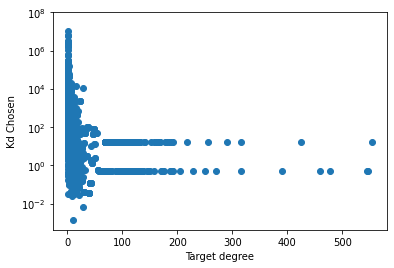

In [26]:
plt.scatter([randomized_combined_unipartite.degree(node) for node in list(randomized_combined_unipartite.nodes())],[np.random.choice(target_random_Kd_dict[node]) for node in list(randomized_combined_unipartite.nodes())])
plt.yscale('log')
plt.xlabel('Target degree')
plt.ylabel('Kd Chosen')
plt.ylim([0,10**8])

In [27]:
stats.spearmanr([randomized_combined_unipartite.degree(node) for node in list(randomized_combined_unipartite.nodes())],[np.random.choice(target_random_Kd_dict[node]) for node in list(randomized_combined_unipartite.nodes())])

SpearmanrResult(correlation=-0.6868883966354218, pvalue=7.447148601306735e-211)

In [28]:
targets_list_1 = []
targets_list_2 = []
Kd_for_edges = []

for edge in tqdm(randomized_combined_unipartite.edges()):
    targets_list_1.append(targets[edge[0]])
    targets_list_2.append(targets[edge[1]])
    mu = np.random.choice(target_random_Kd_dict[edge[0]])
    #if randomized_combined_unipartite.degree(edge[0]) in different_target_annotations:
    #    sigma = unique_Kd_targets_std[different_target_annotations.index(randomized_combined_unipartite.degree(edge[0]))]
    #else:
    #    sigma = 0
    Kd_value_1 = mu # np.random.normal(mu, sigma, 1)
    mu = np.random.choice(target_random_Kd_dict[edge[1]])
    #if randomized_combined_unipartite.degree(edge[1]) in different_target_annotations:
    #    sigma = unique_Kd_targets_std[different_target_annotations.index(randomized_combined_unipartite.degree(edge[1]))]
    #else:
    #    sigma = 0
    Kd_value_2 = mu # np.random.normal(mu, sigma, 1)
    Kd_for_edges.append(float(np.sqrt(Kd_value_1*Kd_value_2))) # float(Kd_value_1+Kd_value_2)/2

100%|██████████| 28726/28726 [00:05<00:00, 5412.57it/s]


In [29]:
K_list_bleh = []
Kd_List_bleh = []
i = 0

for edge in tqdm(randomized_combined_unipartite.edges()):
    K_list_bleh.append(randomized_combined_unipartite.degree(edge[0]))
    K_list_bleh.append(randomized_combined_unipartite.degree(edge[1]))
    Kd_List_bleh.append(Kd_for_edges[i])
    Kd_List_bleh.append(Kd_for_edges[i])
    i = i + 1

100%|██████████| 28726/28726 [00:00<00:00, 112260.37it/s]


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  after removing the cwd from sys.path.


(0.019226480245164358, 100000000)

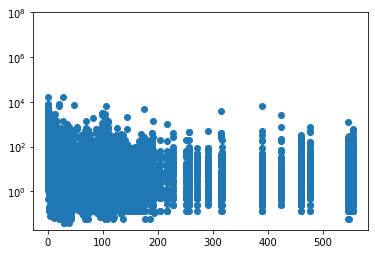

In [30]:
plt.scatter(K_list_bleh,Kd_List_bleh)
#plt.xscale('log')
plt.yscale('log')
plt.ylim([0,10**8])

In [31]:
stats.spearmanr(K_list_bleh,Kd_List_bleh)

SpearmanrResult(correlation=-0.0628710557622365, pvalue=2.055938973712947e-51)

# Making DataFrame

In [32]:
randomized_dataframe = pd.DataFrame()

randomized_dataframe['Target Sequence 1'] = targets_list_1
randomized_dataframe['Target Sequence 2'] = targets_list_2
randomized_dataframe['Label'] = Kd_for_edges

In [33]:
randomized_dataframe

,Target Sequence 1,Target Sequence 2,Label
0,MESLFPAPFWEVLYGSHLQGNLSLLSPNHSGLPPHLLLNASHSAFL...,MSVNSEKSSSSERPEPQQKAPLVPPPPPPPPPPPPPLPDPTPPEPE...,223.437574
1,MESLFPAPFWEVLYGSHLQGNLSLLSPNHSGLPPHLLLNASHSAFL...,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,206.897177
2,MSWATRPPFLPPRHAAGQCGPVGVRKEMHCGVASRWRRRRPWLDPA...,MQPEEGTGWLLELLSEVQLQQYFLRLRDDLNVTRLSHFEYVKNEDL...,36.167678
3,MSWATRPPFLPPRHAAGQCGPVGVRKEMHCGVASRWRRRRPWLDPA...,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,6.330564
4,MSWATRPPFLPPRHAAGQCGPVGVRKEMHCGVASRWRRRRPWLDPA...,MGNYKSRPTQTCTDEWKKKVSESYVITIERLEDDLQIKEKELTELR...,36.167678
...,...,...,...
28721,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,MASTRSIELEHFEERDKRPRPGSRRGAPSSSGGSSSSGPKGNGLIP...,2.758772
28722,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,APITAYAQQTRGLLGCIITSLTGRDKNQVEGEVQIVSTAAQTFLAT...,0.748748
28723,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,2.758772
28724,MRVVVIGAGVIGLSTALCIHERYHSVLQPLDIKVYADRFTPLTTTD...,MGCWGQLLVWFGAAGAILCSSPGSQETFLRSSPLPLASPSPRDPKV...,7.146629


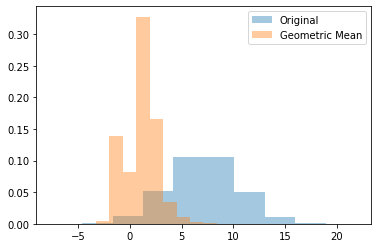

In [57]:
plt.hist(np.log(Kd_copula_list), density=True, label='Original', alpha=0.4) ## Original
plt.hist(np.log(Kd_for_edges), density=True, label='Geometric Mean', alpha=0.4) ## With geomteric mean
plt.legend()

(array([1.7300e+02, 5.1850e+03, 3.0780e+03, 1.2256e+04, 6.2040e+03,
        1.3130e+03, 3.8300e+02, 1.0200e+02, 2.5000e+01, 7.0000e+00]),
 array([-3.30093216, -1.99986292, -0.69879369,  0.60227554,  1.90334477,
         3.204414  ,  4.50548323,  5.80655246,  7.10762169,  8.40869092,
         9.70976015]),
 <a list of 10 Patch objects>)

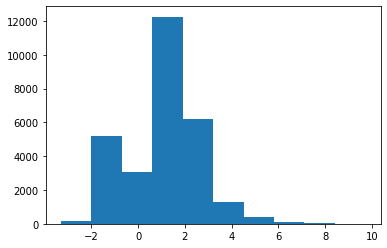

In [34]:
plt.hist(np.log(Kd_for_edges))

In [35]:
threshold = np.exp(np.mean(np.log(Kd_for_edges)) + norm.ppf(0.16) * np.std(np.log(Kd_for_edges))) ## 30 
print('Threshold: ', threshold)

binary_labels = [1 if x < threshold else 0 for x in tqdm(randomized_dataframe['Label'].tolist())]

randomized_dataframe['Label'] = binary_labels

100%|██████████| 28726/28726 [00:00<00:00, 1353724.89it/s]

Threshold:  0.7055802682050327


In [36]:
randomized_dataframe

,Target Sequence 1,Target Sequence 2,Label
0,MESLFPAPFWEVLYGSHLQGNLSLLSPNHSGLPPHLLLNASHSAFL...,MSVNSEKSSSSERPEPQQKAPLVPPPPPPPPPPPPPLPDPTPPEPE...,0
1,MESLFPAPFWEVLYGSHLQGNLSLLSPNHSGLPPHLLLNASHSAFL...,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0
2,MSWATRPPFLPPRHAAGQCGPVGVRKEMHCGVASRWRRRRPWLDPA...,MQPEEGTGWLLELLSEVQLQQYFLRLRDDLNVTRLSHFEYVKNEDL...,0
3,MSWATRPPFLPPRHAAGQCGPVGVRKEMHCGVASRWRRRRPWLDPA...,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,0
4,MSWATRPPFLPPRHAAGQCGPVGVRKEMHCGVASRWRRRRPWLDPA...,MGNYKSRPTQTCTDEWKKKVSESYVITIERLEDDLQIKEKELTELR...,0
...,...,...,...
28721,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,MASTRSIELEHFEERDKRPRPGSRRGAPSSSGGSSSSGPKGNGLIP...,0
28722,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,APITAYAQQTRGLLGCIITSLTGRDKNQVEGEVQIVSTAAQTFLAT...,0
28723,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,0
28724,MRVVVIGAGVIGLSTALCIHERYHSVLQPLDIKVYADRFTPLTTTD...,MGCWGQLLVWFGAAGAILCSSPGSQETFLRSSPLPLASPSPRDPKV...,0


In [37]:
print(randomized_dataframe['Label'].tolist().count(0))
print(randomized_dataframe['Label'].tolist().count(1))

21860
6866


In [73]:
targets = list(set(randomized_dataframe['Target Sequence 1'].tolist()).union(set(randomized_dataframe['Target Sequence 2'].tolist())))

In [74]:
target_annotations_randomized = []
target_pos_degree_randomized = []
target_neg_degree_randomized = []
target_degree_ratio_randomized = []
Kd_targets_average_list = []

for prot in tqdm(targets):
    
    if prot in randomized_dataframe['Target Sequence 1'].tolist() and prot not in randomized_dataframe['Target Sequence 2'].tolist():
        
        sub_df = randomized_dataframe[randomized_dataframe['Target Sequence 1'] == prot]
        target_annotations_randomized.append(len(sub_df))
        target_pos_degree_randomized.append(sub_df['Label'].tolist().count(1))
        target_neg_degree_randomized.append(sub_df['Label'].tolist().count(0))
        target_degree_ratio_randomized.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))
    
    elif prot in randomized_dataframe['Target Sequence 1'].tolist() and prot not in randomized_dataframe['Target Sequence 2'].tolist():
        
        sub_df = randomized_dataframe[randomized_dataframe['Target Sequence 2'] == prot]
        target_annotations_randomized.append(len(sub_df))
        target_pos_degree_randomized.append(sub_df['Label'].tolist().count(1))
        target_neg_degree_randomized.append(sub_df['Label'].tolist().count(0))
        target_degree_ratio_randomized.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))
    
    elif prot in randomized_dataframe['Target Sequence 1'].tolist() and prot in randomized_dataframe['Target Sequence 2'].tolist():
        
        sub_df1 = randomized_dataframe[randomized_dataframe['Target Sequence 1'] == prot]
        sub_df2 = randomized_dataframe[randomized_dataframe['Target Sequence 2'] == prot]
        sub_df = pd.concat([sub_df1,sub_df2])
        target_annotations_randomized.append(len(sub_df))
        target_pos_degree_randomized.append(sub_df['Label'].tolist().count(1))
        target_neg_degree_randomized.append(sub_df['Label'].tolist().count(0))
        target_degree_ratio_randomized.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 1507/1507 [00:11<00:00, 131.92it/s]


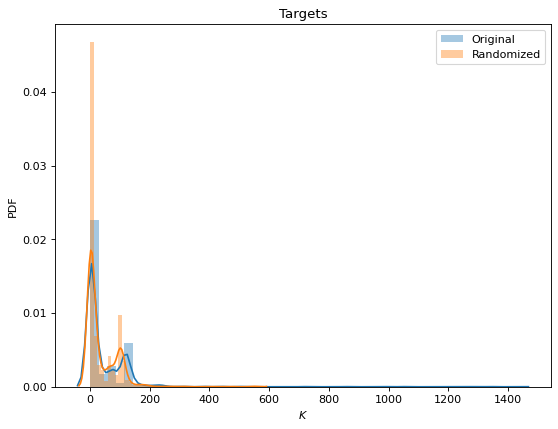

In [75]:
figure(figsize=(8, 6), dpi=80)

sns.distplot(target_annotations_bindingDB, norm_hist=True, label='Original')
sns.distplot([randomized_combined_unipartite.degree(node) for node in list(randomized_combined_unipartite.nodes())], norm_hist=True, label='Randomized')
#axs[3, 0].set_xscale('log')
#axs[3, 0].set_yscale('log')
plt.title('Targets')
plt.xlabel(r'$K$')
plt.ylabel('PDF')
plt.legend()

In [76]:
print('TARGETS')

print('Original - Between k and k+: ', stats.spearmanr(target_annotations_bindingDB, target_pos_degree_bindingDB))
print('Original - Between k and k-: ', stats.spearmanr(target_annotations_bindingDB, target_neg_degree_bindingDB))
print('Original - Between k+ and k-: ', stats.spearmanr(target_pos_degree_bindingDB, target_neg_degree_bindingDB))

print('-------------------------------------------------------------------------------------------------------------')

print('Shuffled - Between k and k+: ', stats.spearmanr(target_annotations_randomized, target_pos_degree_randomized))
print('Shuffled - Between k and k-: ', stats.spearmanr(target_annotations_randomized, target_neg_degree_randomized))
print('Shuffled - Between k+ and k-: ', stats.spearmanr(target_pos_degree_randomized, target_neg_degree_randomized))

TARGETS
Original - Between k and k+:  SpearmanrResult(correlation=0.6581040571662816, pvalue=1.017395698392328e-187)
Original - Between k and k-:  SpearmanrResult(correlation=0.933866781238621, pvalue=0.0)
Original - Between k+ and k-:  SpearmanrResult(correlation=0.4447684177648136, pvalue=4.253892323025037e-74)
-------------------------------------------------------------------------------------------------------------
Shuffled - Between k and k+:  SpearmanrResult(correlation=0.8773693999958553, pvalue=0.0)
Shuffled - Between k and k-:  SpearmanrResult(correlation=0.995341146197699, pvalue=0.0)
Shuffled - Between k+ and k-:  SpearmanrResult(correlation=0.8431227459678112, pvalue=0.0)


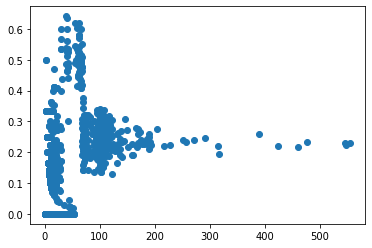

In [77]:
plt.scatter(target_annotations_randomized, target_degree_ratio_randomized)

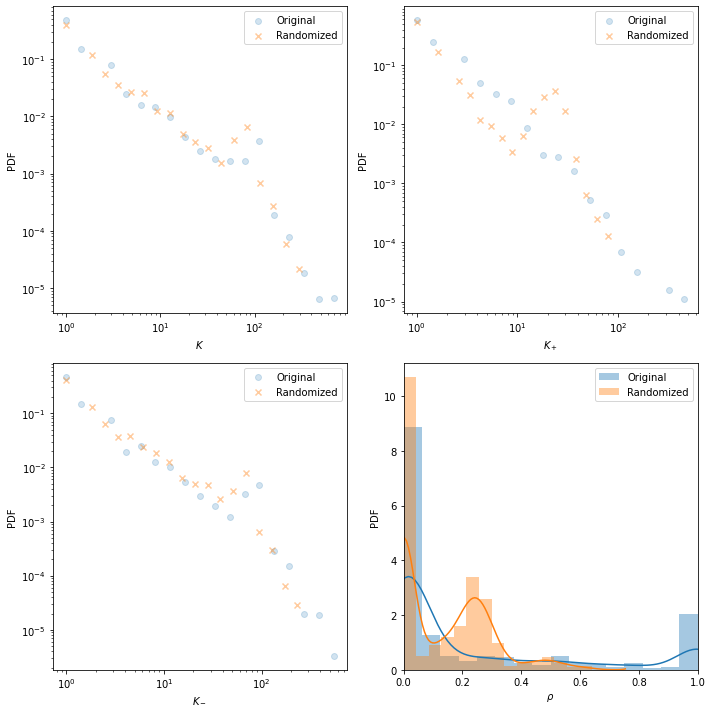

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

binned_deg_ann, binned_ki_ann = log_binning_distribution(target_annotations_bindingDB,B = 20)
axs[0, 0].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(target_annotations_randomized,B = 20)
axs[0, 0].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('$K$')
axs[0, 0].set_ylabel('PDF')
# axs[0, 0].set_title('Targets')
axs[0, 0].legend()

binned_deg_ann, binned_ki_ann = log_binning_distribution(target_pos_degree_bindingDB,B = 20)
axs[0, 1].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(target_pos_degree_randomized,B = 20)
axs[0, 1].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('$K_+$')
axs[0, 1].set_ylabel('PDF')
axs[0, 1].legend()

binned_deg_ann, binned_ki_ann = log_binning_distribution(target_neg_degree_bindingDB,B = 20)
axs[1, 0].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(target_neg_degree_randomized,B = 20)
axs[1, 0].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('$K_-$')
axs[1, 0].set_ylabel('PDF')
axs[1, 0].legend()

#binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_neg_degree_original,B = 20)
sns.distplot(target_degree_ratio_bindingDB, ax=axs[1, 1], norm_hist=True, label='Original')
#axs[3, 0].hist(ligand_degree_ratio_bindingDB_original, label='Original',alpha=0.2)
#binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_neg_degree_shuffled,B = 20)
sns.distplot(target_degree_ratio_randomized, ax=axs[1, 1], norm_hist=True, label='Randomized')
#axs[3, 0].hist(ligand_degree_ratio_bindingDB_shuffled, label='Randomized Kd', alpha=0.2)
#axs[3, 0].set_xscale('log')
#axs[3, 0].set_yscale('log')
axs[1, 1].set_xlabel(r'$\rho$')
axs[1, 1].set_ylabel('PDF')
axs[1, 1].legend()
axs[1, 1].set_xlim([0.0, 1.0])

fig.tight_layout()

In [79]:
np.mean(target_degree_ratio_randomized)

0.13687689113609997

# Duplex Configuration Model

In [44]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(randomized_dataframe, test_size=0.3)

In [45]:
train.to_csv('../../data/Unipartite/experiment_4a/train.csv')
test.to_csv('../../data/Unipartite/experiment_4a/test.csv')

In [46]:
targets = list(set(train['Target Sequence 1'].tolist()).union(set(train['Target Sequence 2'].tolist())))

In [47]:
len(targets)

1410

In [48]:
targets_degree_dict = dict()

for aa_target in tqdm(targets):
    sum_df = train[train['Target Sequence 1'] == aa_target]
    targets_degree_dict[aa_target] = dict()
    targets_degree_dict[aa_target]['deg_0'] = len(sum_df[sum_df['Label'] == 0])
    targets_degree_dict[aa_target]['deg_1'] = len(sum_df[sum_df['Label'] == 1])
    
for aa_target in tqdm(targets):
    sum_df = train[train['Target Sequence 2'] == aa_target]
    if aa_target in targets_degree_dict.keys():
        targets_degree_dict[aa_target]['deg_0'] = targets_degree_dict[aa_target]['deg_0'] + len(sum_df[sum_df['Label'] == 0])
        targets_degree_dict[aa_target]['deg_1'] = targets_degree_dict[aa_target]['deg_1'] + len(sum_df[sum_df['Label'] == 1])
    else:
        targets_degree_dict[aa_target] = dict()
        targets_degree_dict[aa_target]['deg_0'] = len(sum_df[sum_df['Label'] == 0])
        targets_degree_dict[aa_target]['deg_1'] = len(sum_df[sum_df['Label'] == 1])
        
degree_train_1_0_targets = [targets_degree_dict[key_val]['deg_1'] for key_val in tqdm(targets)]
degree_train_0_1_targets = [targets_degree_dict[key_val]['deg_0'] for key_val in tqdm(targets)]

100%|██████████| 1410/1410 [00:00<00:00, 1214616.69it/s]


In [49]:
with open('../../data/Unipartite/experiment_4a/degreetrain10targets.txt', 'w') as file:
    for degree in degree_train_1_0_targets:
        file.write("%i\n" % degree)
        
file.close()

with open('../../data/Unipartite/experiment_4a/degreetrain01targets.txt', 'w') as file:
    for degree in degree_train_0_1_targets:
        file.write("%i\n" % degree)
        
file.close()

textfile = open("../../data/Unipartite/experiment_4a/targets.txt", "w")
for element in targets:
    textfile.write(element + "\n")
textfile.close()

In [50]:
summat10 = np.loadtxt(open("../../data/Unipartite/experiment_4a/summat10.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run
summat01 = np.loadtxt(open("../../data/Unipartite/experiment_4a/summat01.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run 

In [51]:
train_pos = train[train['Label'] == 1]
train_neg = train[train['Label'] == 0]

pos_deg_0_targets = []
neg_deg_0_targets = []

targets_degree_ratio = dict()
target_all_average = []

for target in tqdm(targets):
    pos_deg = targets_degree_dict[target]['deg_1']
    neg_deg = targets_degree_dict[target]['deg_0']
    if pos_deg + neg_deg != 0:
        targets_degree_ratio[target] = dict()
        targets_degree_ratio[target]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
        targets_degree_ratio[target]['deg_avg'] = pos_deg / len(targets)
        target_all_average.append(pos_deg / len(targets))
    if pos_deg == 0:
        pos_deg_0_targets.append(target)
    if neg_deg == 0:
        neg_deg_0_targets.append(target)
    
targets_all_avg = sum(target_all_average) / len(targets)

100%|██████████| 1410/1410 [00:00<00:00, 332656.58it/s]


In [52]:
## Annotated means the node has at least 1 binding information

pos_annotated_targets = list(set(targets)-set(pos_deg_0_targets))

neg_annotated_targets = list(set(targets)-set(neg_deg_0_targets))

In [53]:
test_probabilty_predicted_conditioned = []

## Average conditional probability
p10_avg = np.mean(summat10)
p01_avg = np.mean(summat01)
average_conditional_probability = p10_avg / (p10_avg + p01_avg)

for index, row in tqdm(test.iterrows()):      
    
    if row['Target Sequence 1'] in pos_annotated_targets and row['Target Sequence 2'] in pos_annotated_targets:
        p10 = summat10[targets.index(row['Target Sequence 1']),targets.index(row['Target Sequence 2'])]
        p01 = summat01[targets.index(row['Target Sequence 1']),targets.index(row['Target Sequence 2'])]
        p10_conditioned = p10 / (p10 + p01)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['Target Sequence 1'] in pos_annotated_targets and row['Target Sequence 2'] not in pos_annotated_targets:
        p10_conditioned = targets_degree_ratio[row['Target Sequence 1']]['deg_ratio']  ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['Target Sequence 1'] not in pos_annotated_targets and row['Target Sequence 2'] in pos_annotated_targets:
        p10_conditioned = targets_degree_ratio[row['Target Sequence 2']]['deg_ratio'] ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)

    else:
        p10_conditioned = average_conditional_probability
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        

1191it [00:00, 3935.39it/s]/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
8618it [00:02, 3991.77it/s]


In [55]:
test['test_probabilty_predicted_conditioned'] = test_probabilty_predicted_conditioned
test = test[~test['test_probabilty_predicted_conditioned'].isna()]

train_targets1 = list(set(train['Target Sequence 1'].tolist()))
train_targets2 = list(set(train['Target Sequence 2'].tolist()))

test_minus_train_targets1 = list(set(test['Target Sequence 1'].tolist()).difference(train_targets1))
test_minus_train_targets2 = list(set(test['Target Sequence 2'].tolist()).difference(train_targets2))

print('Seen targets 1: ', len(train_targets1))
print('Seen targets 2: ', len(train_targets2))
print('Unseen targets 1: ', len(test_minus_train_targets1))
print('Unseen targets 2: ', len(test_minus_train_targets2))

Seen targets 1:  1194
Seen targets 2:  1098
Unseen targets 1:  96
Unseen targets 2:  78


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
# Unseen Edges

test_unseen_edges = test[test['Target Sequence 1'].isin(train_targets1) & test['Target Sequence 2'].isin(train_targets2)]
print('Unseen edges: ', len(test_unseen_edges))

print('AUC: ', roc_auc_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['test_probabilty_predicted_conditioned']))
print('AUP: ', average_precision_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['test_probabilty_predicted_conditioned']))

Unseen edges:  8399
AUC:  0.5985929102219111
AUP:  0.35796225201947146


In [80]:
# Unseen Targets

#test_unseen_targets = test[test['Target Sequence'].isin(test_minus_train_targets)]
#print('Unseen targets: ', len(test_unseen_targets))

#append = pd.DataFrame()

#append['SMILES'] = ['x']
#append['Target Sequence'] = ['y']
#append['Label'] = [1.0]
#append['test_probabilty_predicted_conditioned'] = [np.mean(test_unseen_targets['test_probabilty_predicted_conditioned'].tolist())]

#test_unseen_targets = pd.concat([test_unseen_targets,append])

#print('AUC: ', roc_auc_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['test_probabilty_predicted_conditioned']))
#print('AUP: ', average_precision_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['test_probabilty_predicted_conditioned']))

In [81]:
# Unseen Nodes

#test_unseen_nodes = test[test['Target Sequence 1'].isin(test_minus_train_targets1) & test['Target Sequence 2'].isin(test_minus_train_targets2)]
#print('Unseen nodes: ', len(test_unseen_nodes))

#append = pd.DataFrame()

#append['SMILES'] = ['x']
#append['Target Sequence'] = ['y']
#append['Label'] = [1.0]
#append['test_probabilty_predicted_conditioned'] = [np.mean(test_unseen_nodes['test_probabilty_predicted_conditioned'].tolist())]

#test_unseen_nodes = pd.concat([test_unseen_nodes,append])

#print('AUC: ', roc_auc_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['test_probabilty_predicted_conditioned']))
#print('AUP: ', average_precision_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['test_probabilty_predicted_conditioned']))

# Comparison with Original

In [220]:
# original_test = pd.read_csv('../../data/Transformer_CNN_test_w_config_preds_fold2.csv')

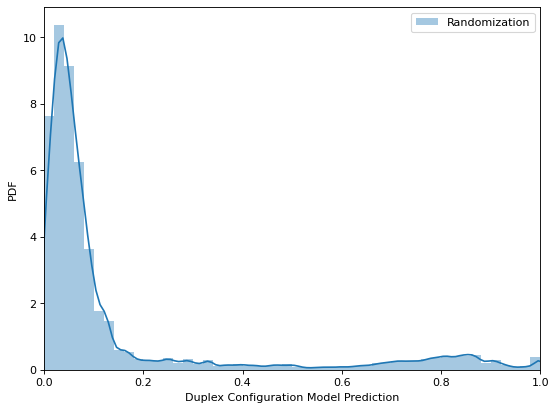

In [60]:
figure(figsize=(8, 6), dpi=80)

#sns.distplot(original_test['duplex_config_prediction'].tolist(),  norm_hist=True, label='Original')
sns.distplot(test['test_probabilty_predicted_conditioned'].tolist(),  norm_hist=True, label='Randomization')
plt.legend()
plt.xlim([0,1])
plt.xlabel('Duplex Configuration Model Prediction')
plt.ylabel('PDF')
plt.show()

In [61]:
#print('Older mean and std of duplex prediction: ', np.mean(original_test['duplex_config_prediction'].tolist()), np.std(original_test['duplex_config_prediction'].tolist()))
print('New mean and std of duplex prediction: ', np.mean(test['test_probabilty_predicted_conditioned'].tolist()), np.std(test['test_probabilty_predicted_conditioned'].tolist()))

New mean and std of duplex prediction:  0.1495644536650273 0.24062024638016755


In [59]:
test.to_csv('../../data/Unipartite/experiment_4a/test.csv')

In [61]:
test_0p05 = pd.read_csv('../../data/Unipartite/4a_pbind_0p05/test.csv')
test_0p5 = pd.read_csv('../../data/Unipartite/4a_pbind_0p5/test.csv')

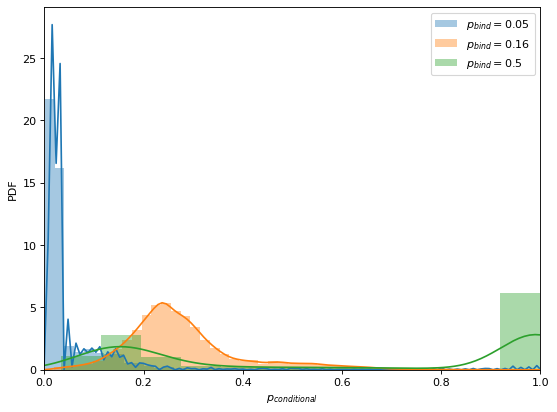

In [64]:
figure(figsize=(8, 6), dpi=80)

#sns.distplot(original_test['duplex_config_prediction'].tolist(),  norm_hist=True, label='Original')
sns.distplot(test_0p05['test_probabilty_predicted_conditioned'].tolist(),  norm_hist=True, label=r'$p_{bind} = 0.05$')
sns.distplot(test['test_probabilty_predicted_conditioned'].tolist(),  norm_hist=True, label=r'$p_{bind} = 0.16$')
sns.distplot(test_0p5['test_probabilty_predicted_conditioned'].tolist(),  norm_hist=True, label=r'$p_{bind} = 0.5$')
plt.legend()
plt.xlim([0,1])
plt.xlabel(r'$p_{conditional}$')
plt.ylabel('PDF')
plt.show()

In [63]:
print('Mean and STD for pbind of 0.05: ', np.mean(test_0p05['test_probabilty_predicted_conditioned'].tolist()), np.std(test_0p05['test_probabilty_predicted_conditioned'].tolist()))
print('Mean and STD for pbind of 0.16: ', np.mean(test['test_probabilty_predicted_conditioned'].tolist()), np.std(test['test_probabilty_predicted_conditioned'].tolist()))
print('Mean and STD for pbind of 0.50: ', np.mean(test_0p5['test_probabilty_predicted_conditioned'].tolist()), np.std(test_0p5['test_probabilty_predicted_conditioned'].tolist()))

Mean and STD for pbind of 0.05:  0.055092441466748285 0.10949113316687942
Mean and STD for pbind of 0.16:  0.2794244037971329 0.11967142396151494
Mean and STD for pbind of 0.50:  0.612425559704208 0.39836250439181004
